In [1]:
%matplotlib inline


# NLP From Scratch: Translation with a Sequence to Sequence Network and Attention
**Author**: [Sean Robertson](https://github.com/spro)

This is the third and final tutorial on doing "NLP From Scratch", where we
write our own classes and functions to preprocess the data to do our NLP
modeling tasks. We hope after you complete this tutorial that you'll proceed to
learn how `torchtext` can handle much of this preprocessing for you in the
three tutorials immediately following this one.

In this project we will be teaching a neural network to translate from
French to English.

```sh
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```
... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215)_, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

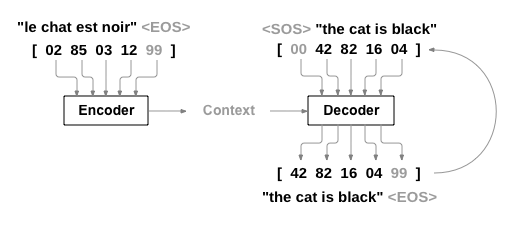

To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473)_, which lets the decoder
learn to focus over a specific range of the input sequence.


# 기초부터 시작하는 NLP: Sequence to Sequence 네트워크와 Attention을 이용한 번역
**Author**: [Sean Robertson](https://github.com/spro/practical-pytorch)
  **번역**: [황성수](https://github.com/adonisues)

이 튜토리얼은 "기초부터 시작하는 NLP"의 세번째이자 마지막 편으로, NLP 모델링 작업을
위한 데이터 전처리에 사용할 자체 클래스와 함수들을 작성해보겠습니다.
이 튜토리얼을 마친 뒤에는 `torchtext` 가 어떻게 지금까지의 튜토리얼들에서의
전처리 과정을 다루는지를 이후 튜토리얼들에서 배울 수 있습니다.

이 프로젝트에서는 신경망이 불어를 영어로 번역하도록 가르칠 예정입니다.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... 성공율은 변할 수 있습니다.

하나의 시퀀스를 다른 시퀀스로 바꾸는 두개의 RNN이 함께 동작하는
[sequence to sequence network](https://arxiv.org/abs/1409.3215)_ 의 간단하지만 강력한 아이디어가
이것(번역)을 가능하게 합니다. 인코더 네트워크는 입력 시퀀스를 벡터로 압축하고,
디코더 네트워크는 해당 벡터를 새로운 시퀀스로 펼칩니다.

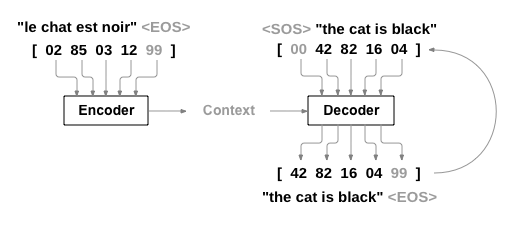

이 모델을 개선하기 위해 [Attention Mechanism](https://arxiv.org/abs/1409.0473)_ 을
사용하면 디코더가 입력 시퀀스의 특정 범위에 집중할 수 있도록 합니다.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata, re, random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading data files

The data for this project is a set of many thousands of English to
French translation pairs.

[This question on Open Data Stack
Exchange](https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages)_
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repository, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

```sh
I am cold.    J'ai froid.
```
<div class="alert alert-info"><h4>Note</h4><p>Download the data from
   [here](https://download.pytorch.org/tutorial/data.zip)
   and extract it to the current directory.</p></div>



## 데이터 파일 로딩

이 프로젝트의 데이터는 수천 개의 영어-프랑스어 번역 쌍입니다.

이 파일은 탭으로 구분된 번역 쌍 목록입니다:

    I am cold.    J'ai froid.

.. Note::
   [여기](https://download.pytorch.org/tutorial/data.zip)
   에서 데이터를 다운 받고 현재 디렉토리에 압축을 푸십시오.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` which will be used to replace rare words later.




문자 단위 RNN 튜토리얼에서 사용된 문자 인코딩과 유사하게, 언어의 각
단어들을 One-Hot 벡터 또는 그 단어의 주소에만 단 하나의 1을 제외하고
모두 0인 큰 벡터로 표현합니다. 한 가지 언어에 있는 수십 개의 문자와
달리 번역에는 아주 많은 단어들이 있기 때문에 인코딩 벡터는 매우 더 큽니다.
그러나 우리는 약간의 트릭를 써서 언어 당 수천 단어 만
사용하도록 데이터를 다듬을 것입니다.

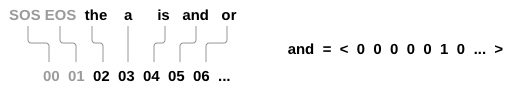

나중에 네트워크의 입력 및 목표로 사용하려면 단어 당 고유 번호가
필요합니다. 이 모든 것을 추적하기 위해 우리는
단어→색인(``word2index``)과 색인→단어(``index2word``) 사전,
그리고 나중에 희귀 단어를 대체하는데 사용할 각 단어의 빈도
``word2count`` 를 가진 ``Lang`` 이라는 헬퍼 클래스를 사용합니다.




In [5]:
import os, zipfile
from pathlib import Path

with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extractall()

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




파일은 모두 유니 코드로 되어있어 간단하게 하기 위해 유니 코드 문자를
ASCII로 변환하고, 모든 문자를 소문자로 만들고, 대부분의 구두점을
지워줍니다.




In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [14]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines....")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




*많은* 예제 문장이 있고 신속하게 학습하기를 원하기 때문에
비교적 짧고 간단한 문장으로만 데이터 셋을 정리할 것입니다. 여기서
최대 길이는 10 단어 (종료 문장 부호 포함)이며 "I am" 또는
"He is" 등의 형태로 번역되는 문장으로 필터링됩니다.(이전에
아포스트로피는 대체 됨)




In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are ", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




데이터 준비를 위한 전체 과정:

-  텍스트 파일을 읽고 줄로 분리하고, 줄을 쌍으로 분리합니다.
-  텍스트를 정규화 하고 길이와 내용으로 필터링 합니다.
-  쌍을 이룬 문장들로 단어 리스트를 생성합니다.




In [15]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words....")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines....
Read 135842 sentence pairs
Trimmed to 11440 sentence pairs
Counting words....
Counted words:
fra 4601
eng 2991
['je suis convaincu d avoir le bon numero', 'i m sure i have the right number']


## The Seq2Seq Model

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215)_, or
seq2seq network, or [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf)_, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

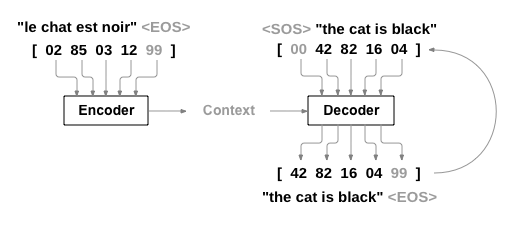

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence ``Je ne suis pas le chat noir`` → ``I am not the
black cat``. Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. ``chat noir`` and ``black cat``. Because of the ``ne/pas``
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.


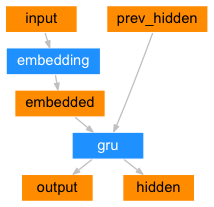



## Seq2Seq 모델

Recurrent Neural Network(RNN)는 시퀀스에서 작동하고 다음 단계의
입력으로 자신의 출력을 사용하는 네트워크입니다.

[Sequence to Sequence network](https://arxiv.org/abs/1409.3215)_, 또는
Seq2Seq 네트워크, 또는 [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf)_ 는 인코더 및
디코더라고 하는 두 개의 RNN으로 구성된 모델입니다.
인코더는 입력 시퀀스를 읽고 단일 벡터를 출력하고,
디코더는 해당 벡터를 읽어 출력 시퀀스를 생성합니다.


모든 입력에 해당하는 출력이 있는 단일 RNN의 시퀀스 예측과 달리
Seq2Seq 모델은 시퀀스 길이와 순서를 자유롭게하기 때문에
두 언어 사이의 번역에 이상적입니다.

다음 문장 ``Je ne suis pas le chat noir`` → ``I am not the black cat``
를 살펴 봅시다. 입력 문장의 단어 대부분은 출력 문장에서
직역(``chat noir`` 와 ``black cat``)되지만 약간 다른 순서도 있습니다.
``ne/pas`` 구조로 인해 입력 문장에 단어가 하나 더 있습니다.
입력 단어의 시퀀스를 직역해서 정확한 번역을 만드는
것은 어려울 것입니다.

Seq2Seq 모델을 사용하면 인코더는 하나의 벡터를 생성합니다.
이상적인 경우에 입력 시퀀스의 "의미"를 문장의 N 차원 공간에 있는
단일 지점인 단일 벡터으로 인코딩합니다.




### 인코더

Seq2Seq 네트워크의 인코더는 입력 문장의 모든 단어에 대해 어떤 값을
출력하는 RNN입니다. 모든 입력 단어에 대해 인코더는 벡터와
은닉 상태를 출력하고 다음 입력 단어를 위해 그 은닉 상태를 사용합니다.





In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




#### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

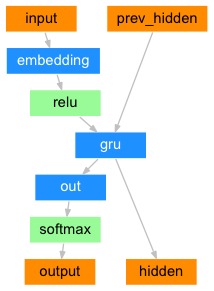

### 디코더

디코더는 인코더 출력 벡터를 받아서 번역을 생성하기 위한 단어 시퀀스를
출력합니다.




#### 간단한 디코더

가장 간단한 Seq2Seq 디코더는 인코더의 마지막 출력만을 이용합니다.
이 마지막 출력은 전체 시퀀스에서 문맥을 인코드하기 때문에
*문맥 벡터(context vector)* 로 불립니다. 이 문맥 벡터는 디코더의 초기 은닉 상태로
사용 됩니다.

디코딩의 매 단계에서 디코더에게 입력 토큰과 은닉 상태가 주어집니다.
초기 입력 토큰은 문자열-시작 (start-of-string) ``<SOS>`` 토큰이고,
첫 은닉 상태는 문맥 벡터(인코더의 마지막 은닉 상태) 입니다.




In [18]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach() # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




#### Attention Decoder

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

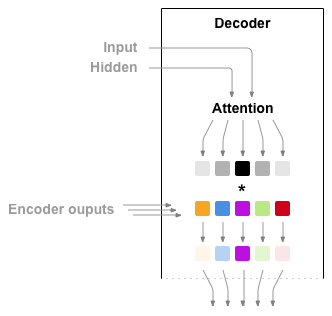

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

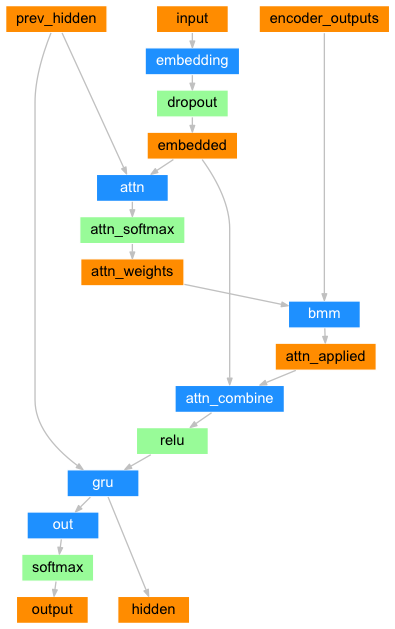


Bahdanau attention, also known as additive attention, is a commonly used
attention mechanism in sequence-to-sequence models, particularly in neural
machine translation tasks. It was introduced by Bahdanau et al. in their
paper titled [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf)_.
This attention mechanism employs a learned alignment model to compute attention
scores between the encoder and decoder hidden states. It utilizes a feed-forward
neural network to calculate alignment scores.

However, there are alternative attention mechanisms available, such as Luong attention,
which computes attention scores by taking the dot product between the decoder hidden
state and the encoder hidden states. It does not involve the non-linear transformation
used in Bahdanau attention.

In this tutorial, we will be using Bahdanau attention. However, it would be a valuable
exercise to explore modifying the attention mechanism to use Luong attention.



#### Attention 디코더

문맥 벡터만 인코더와 디코더 사이로 전달 된다면, 단일 벡터가 전체 문장을
인코딩 해야하는 부담을 가지게 됩니다.

Attention은 디코더 네트워크가 자기 출력의 모든 단계에서 인코더 출력의
다른 부분에 "집중" 할 수 있게 합니다. 첫째 *Attention 가중치* 의 세트를
계산합니다. 이것은 가중치 조합을 만들기 위해서 인코더 출력 벡터와
곱해집니다. 그 결과(코드에서 ``attn_applied``)는 입력 시퀀스의
특정 부분에 관한 정보를 포함해야하고 따라서 디코더가 알맞은 출력
단어를 선택하는 것을 도와줍니다.



어텐션 가중치 계산은 디코더의 입력 및 은닉 상태를 입력으로
사용하는 다른 feed-forwad 계층인 ``attn`` 으로 수행됩니다.
학습 데이터에는 모든 크기의 문장이 있기 때문에 이 계층을 실제로
만들고 학습시키려면 적용 할 수 있는 최대 문장 길이 (인코더 출력을 위한 입력 길이)를
선택해야 합니다. 최대 길이의 문장은 모든 Attention 가중치를 사용하지만
더 짧은 문장은 처음 몇 개만 사용합니다.







In [20]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach() # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in [Effective Approaches to Attention-based Neural Machine
  Translation](https://arxiv.org/abs/1508.04025)_.</p></div>

## Training

### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




## 학습

### 학습 데이터 준비

학습을 위해서, 각 쌍마다 입력 Tensor(입력 문장의 단어 주소)와
목표 Tensor(목표 문장의 단어 주소)가 필요합니다. 이 벡터들을
생성하는 동안 두 시퀀스에 EOS 토큰을 추가 합니다.




In [22]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

### Training the Model

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but [when the trained
network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf)_.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




### 모델 학습

학습을 위해서 인코더에 입력 문장을 넣고 모든 출력과 최신 은닉 상태를
추적합니다. 그런 다음 디코더에 첫 번째 입력으로 ``<SOS>`` 토큰과
인코더의 마지막 은닉 상태가 첫 번째 은닉 상태로 제공됩니다.

"Teacher forcing"은 다음 입력으로 디코더의 예측을 사용하는 대신
실제 목표 출력을 다음 입력으로 사용하는 컨셉입니다.
"Teacher forcing"을 사용하면 수렴이 빨리되지만 [학습된 네트워크가
잘못 사용될 때 불안정성을 보입니다.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf)_.

Teacher-forced 네트워크의 출력이 일관된 문법으로 읽지만 정확한
번역과는 거리가 멀다는 것을 볼 수 있습니다. 직관적으로 출력 문법을
표현하는 법을 배우고 교사가 처음 몇 단어를 말하면 의미를 "선택" 할 수 있지만,
번역에서 처음으로 문장을 만드는 법은 잘 배우지 못합니다.

PyTorch의 autograd 가 제공하는 자유 덕분에 간단한 If 문으로
Teacher Forcing을 사용할지 아니면 사용하지 않을지를 선택할 수 있습니다.
더 많이 사용하려면 ``teacher_forcing_ratio`` 를 확인하십시오.




In [23]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




이것은 현재 시간과 진행률%을 고려해 경과된 시간과 남은 예상
시간을 출력하는 헬퍼 함수입니다.




In [24]:
import time, math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




전체 학습 과정은 다음과 같습니다:

-  타이머 시작
-  optimizers와 criterion 초기화
-  학습 쌍의 세트 생성
-  도식화를 위한 빈 손실 배열 시작

그런 다음 우리는 여러 번 ``train`` 을 호출하며 때로는 진행률
(예제의 %, 현재까지의 예상 시간)과 평균 손실을 출력합니다.




In [26]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=100, plot_every=100):

    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




### 결과 도식화

matplotlib로 학습 중에 저장된 손실 값 ``plot_losses`` 의 배열을
사용하여 도식화합니다.




In [27]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks as regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




## 평가

평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 디코더의
예측을 되돌려 전달합니다.
단어를 예측할 때마다 그 단어를 출력 문자열에 추가합니다.
만약 EOS 토큰을 예측하면 거기에서 멈춥니다.
나중에 도식화를 위해서 디코더의 Attention 출력을 저장합니다.




In [34]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




학습 세트에 있는 임의의 문장을 평가하고
입력, 목표 및 출력을 출력하여 주관적인 품질 판단을 내릴 수 있습니다:




In [35]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

<div class="alert alert-info"><h4>Note</h4><p>If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.</p></div>




## 학습과 평가

이러한 모든 헬퍼 함수를 이용해서 (추가 작업처럼 보이지만 여러 실험을
더 쉽게 수행 할 수 있음) 실제로 네트워크를 초기화하고 학습을
시작할 수 있습니다.

입력 문장이 많이 필터링되었음을 기억하십시오. 이 작은 데이터 세트의
경우 256 크기의 은닉 노드(hidden node)와 단일 GRU 계층 같은 상대적으로 작은
네트워크를 사용할 수 있습니다. MacBook CPU에서 약 40분 후에
합리적인 결과를 얻을 것입니다.

.. Note::
   이 노트북을 실행하면 학습, 커널 중단, 평가를 할 수 있고 나중에
   이어서 학습을 할 수 있습니다. 인코더와 디코더가 초기화 된 행을
   주석 처리하고 ``trainIters`` 를 다시 실행하십시오.




In [30]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines....
Read 135842 sentence pairs
Trimmed to 11440 sentence pairs
Counting words....
Counted words:
fra 4601
eng 2991
3m 41s (- 55m 18s) (5 6%) 1.5466
8m 29s (- 59m 23s) (10 12%) 0.6862
11m 45s (- 50m 57s) (15 18%) 0.3538
15m 1s (- 45m 5s) (20 25%) 0.1950
18m 16s (- 40m 13s) (25 31%) 0.1203
21m 33s (- 35m 55s) (30 37%) 0.0827
24m 51s (- 31m 57s) (35 43%) 0.0633
28m 7s (- 28m 7s) (40 50%) 0.0515
31m 18s (- 24m 21s) (45 56%) 0.0452
34m 32s (- 20m 43s) (50 62%) 0.0400
37m 46s (- 17m 10s) (55 68%) 0.0374
40m 59s (- 13m 39s) (60 75%) 0.0354
44m 13s (- 10m 12s) (65 81%) 0.0327
47m 30s (- 6m 47s) (70 87%) 0.0311
50m 43s (- 3m 22s) (75 93%) 0.0305
53m 56s (- 0m 0s) (80 100%) 0.0297


Set dropout layers to ``eval`` mode



In [36]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> c est un auteur
= he s an author


RuntimeError: a Tensor with 10 elements cannot be converted to Scalar

### Visualizing Attention

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix. For a better viewing experience we will do the
extra work of adding axes and labels:




### Attention 시각화

Attention 메커니즘의 유용한 속성은 하나는 해석 가능성이 높은 출력입니다.
입력 시퀀스의 특정 인코더 출력에 가중치를 부여하는 데 사용되므로
각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악할 수 있습니다.

Attention 출력을 행렬로 표시하기 위해 ``plt.matshow(attentions)`` 를
간단하게 실행할 수 있습니다. 열은 입력 단계와 행이 출력 단계입니다:




In [37]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)

    print('input=', input_sentence)
    print('output=', ' '.join(output_words))

    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

RuntimeError: a Tensor with 10 elements cannot be converted to Scalar

## Exercises

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pretrained word embeddings such as ``word2vec`` or
   ``GloVe``
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there




## 연습

-  다른 데이터 셋을 시도해 보십시오

   -  다른 언어쌍
   -  사람 → 기계 (e.g. IOT 명령어)
   -  채팅 → 응답
   -  질문 → 답변

-  ``word2vec`` 또는 ``GloVe`` 같은 미리 학습된 word embedding 으로
   embedding 을 교체하십시오

-  더 많은 레이어, 은닉 유닛, 더 많은 문장을 사용하십시오.
   학습 시간과 결과를 비교해 보십시오
-  만약 같은 구문 두개의 쌍으로 된 번역 파일을 이용한다면,
   (``I am test \t I am test``), 이것을 오토인코더로
   사용할 수 있습니다.
   이것을 시도해 보십시오:

   -  오토인코더 학습
   -  인코더 네트워크 저장하기
   -  그 상태에서 번역을 위한 새로운 디코더 학습


